In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import sys
import shutil
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
from scipy import sparse

import bottleneck as bn
import matplotlib.pyplot as plt
import seaborn as sn
sn.set()

import tensorflow as tf

MOVIELENS_DIR = '/content/drive/MyDrive/Shortcuts/MovieLens/ml-20m'

RATINGS_FILE = os.path.join(MOVIELENS_DIR, 'ratings.csv')


def count_by_column(df: pd.DataFrame, col: str) -> pd.Series:
    return df.groupby(col).size()


def filter_by_min_counts(
    df: pd.DataFrame,
    min_user_count: int = 0,
    min_item_count: int = 5,
) -> Tuple[pd.DataFrame, pd.Series, pd.Series]:
    working_df = df.copy()
    if min_item_count > 0:
        item_counts = count_by_column(working_df, 'movieId')
        eligible_items = item_counts[item_counts >= min_item_count].index
        working_df = working_df[working_df['movieId'].isin(eligible_items)]
    if min_user_count > 0:
        user_counts = count_by_column(working_df, 'userId')
        eligible_users = user_counts[user_counts >= min_user_count].index
        working_df = working_df[working_df['userId'].isin(eligible_users)]
    user_counts = count_by_column(working_df, 'userId')
    item_counts = count_by_column(working_df, 'movieId')
    return working_df, user_counts, item_counts


def split_by_prop(
    data: pd.DataFrame,
    test_fraction: float = 0.2,
    min_user_items: int = 5,
    random_seed: int = 98765,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    rng = np.random.RandomState(random_seed)
    grouped = data.groupby('userId')
    train_list: List[pd.DataFrame] = []
    test_list: List[pd.DataFrame] = []
    for i, (_, group) in enumerate(grouped):
        num_items = len(group)
        if num_items >= min_user_items:
            num_test = int(test_fraction * num_items)
            num_test = max(num_test, 1)
            test_indices = rng.choice(num_items, size=num_test, replace=False)
            mask = np.zeros(num_items, dtype=bool)
            mask[test_indices] = True
            train_list.append(group.loc[~mask])
            test_list.append(group.loc[mask])
        else:
            train_list.append(group)
        if i % 1000 == 0:
            print(f"Processed {i} users for splitting")
            sys.stdout.flush()
    train_df = pd.concat(train_list, axis=0)
    test_df = pd.concat(test_list, axis=0) if test_list else data.iloc[0:0].copy()
    return train_df, test_df


def map_ids(df: pd.DataFrame, user_map: Dict[int, int], item_map: Dict[int, int]) -> pd.DataFrame:
    uid = df['userId'].map(user_map)
    sid = df['movieId'].map(item_map)
    ratings = df['val'].astype(np.float32)
    mapped_df = pd.DataFrame({'uid': uid, 'sid': sid, 'val': ratings}).dropna()
    return mapped_df.astype({'uid': 'int64', 'sid': 'int64', 'val': 'float32'})


def build_sparse_matrix(tp: pd.DataFrame, num_items: int) -> sparse.csr_matrix:
    tp_unique = tp.drop_duplicates(subset=['uid', 'sid'], keep='last')
    n_users = int(tp_unique['uid'].max()) + 1
    rows = tp_unique['uid'].to_numpy()
    cols = tp_unique['sid'].to_numpy()
    vals = tp_unique['val'].to_numpy(dtype=np.float32)
    return sparse.csr_matrix((vals, (rows, cols)), dtype=np.float32, shape=(n_users, num_items))


def build_train_test_mats(
    train_df: pd.DataFrame,
    test_df: pd.DataFrame,
    num_items: int,
) -> Tuple[sparse.csr_matrix, sparse.csr_matrix]:
    train_unique = train_df.drop_duplicates(subset=['uid', 'sid'], keep='last')
    test_unique = test_df.drop_duplicates(subset=['uid', 'sid'], keep='last')
    start_idx = min(train_unique['uid'].min(), test_unique['uid'].min())
    end_idx = max(train_unique['uid'].max(), test_unique['uid'].max())
    n_users = end_idx - start_idx + 1
    rows_tr = (train_unique['uid'] - start_idx).to_numpy()
    cols_tr = train_unique['sid'].to_numpy()
    vals_tr = train_unique['val'].to_numpy(dtype=np.float32)
    train_mat = sparse.csr_matrix((vals_tr, (rows_tr, cols_tr)), dtype=np.float32, shape=(n_users, num_items))
    rows_te = (test_unique['uid'] - start_idx).to_numpy()
    cols_te = test_unique['sid'].to_numpy()
    vals_te = test_unique['val'].to_numpy(dtype=np.float32)
    test_mat = sparse.csr_matrix((vals_te, (rows_te, cols_te)), dtype=np.float32, shape=(n_users, num_items))
    return train_mat, test_mat

def ndcg_score_batch(scores: np.ndarray, heldout: sparse.csr_matrix, k: int = 100) -> np.ndarray:
    batch_size = scores.shape[0]
    idx_part = bn.argpartition(-scores, k, axis=1)
    topk_part = scores[np.arange(batch_size)[:, None], idx_part[:, :k]]
    idx_sort = np.argsort(-topk_part, axis=1)
    idx_topk = idx_part[np.arange(batch_size)[:, None], idx_sort]
    discounts = 1. / np.log2(np.arange(2, k + 2))
    rel_mat = (heldout > 0).tocsr()
    rel = rel_mat[np.arange(batch_size)[:, None], idx_topk].toarray().astype(np.float32)
    dcg = (rel * discounts).sum(axis=1)
    n_pos = np.asarray(rel_mat.getnnz(axis=1)).reshape(-1)
    idcg = np.array([discounts[:min(int(n), k)].sum() for n in n_pos], dtype=np.float32)
    ndcg = np.divide(dcg, idcg, out=np.zeros_like(dcg, dtype=np.float32), where=idcg > 0)
    return ndcg


def negative_hit_rate_batch(scores: np.ndarray, heldout: sparse.csr_matrix, k: int = 100) -> np.ndarray:
    batch_size = scores.shape[0]
    idx_part = bn.argpartition(-scores, k, axis=1)
    topk_part = scores[np.arange(batch_size)[:, None], idx_part[:, :k]]
    idx_sort = np.argsort(-topk_part, axis=1)
    idx_topk = idx_part[np.arange(batch_size)[:, None], idx_sort]
    neg_mat = (heldout < 0).tocsr()
    neg_hits = neg_mat[np.arange(batch_size)[:, None], idx_topk].toarray().sum(axis=1)
    return (neg_hits / float(k)).astype(np.float32)


def recall_at_k_batch(scores: np.ndarray, heldout: sparse.csr_matrix, k: int = 100) -> np.ndarray:
    batch_size = scores.shape[0]
    idx = bn.argpartition(-scores, k, axis=1)
    pred_binary = np.zeros_like(scores, dtype=bool)
    pred_binary[np.arange(batch_size)[:, None], idx[:, :k]] = True
    true_binary = (heldout > 0).toarray()
    intersection = (np.logical_and(true_binary, pred_binary).sum(axis=1)).astype(np.float32)
    denom = np.minimum(k, true_binary.sum(axis=1))
    recall = np.divide(intersection, denom, out=np.zeros_like(intersection, dtype=np.float32), where=denom > 0)
    return recall

def l2_regulariser(scale: float):
    scale = float(scale)
    def _reg(w):
        return tf.multiply(scale, tf.nn.l2_loss(w))
    return _reg


def apply_reg_to_weights(regulariser, weight_dict: List[tf.Variable]) -> tf.Tensor:
    terms = [regulariser(w) for w in weight_dict]
    return tf.add_n(terms) if terms else tf.constant(0.0, dtype=tf.float32)


class DenoisingAutoEncoder(object):
    def __init__(
        self,
        p_dims: List[int],
        q_dims: List[int] = None,
        lam: float = 0.01,
        lr: float = 1e-3,
        random_seed: int = None,
    ):
        # Decoder dimensions
        self.p_dims = list(p_dims)
        # Inference (encoder) dimensions
        if q_dims is None:
            self.q_dims = self.p_dims[::-1]
        else:
            assert q_dims[0] == self.p_dims[-1], (
                "Encoder output dimension must match decoder input dimension."
            )
            assert q_dims[-1] == self.p_dims[0], (
                "Latent dimension mismatch between encoder and decoder."
            )
            self.q_dims = list(q_dims)
        self.layer_dims = self.q_dims + self.p_dims[1:]
        self.lam = lam
        self.lr = lr
        self.random_seed = random_seed

    def init_placeholders(self):
        self.input_ph = tf.compat.v1.placeholder(tf.float32, shape=[None, self.layer_dims[0]])
        self.keep_prob_ph = tf.compat.v1.placeholder_with_default(1.0, shape=())

    def init_weights(self):
        self.weights: List[tf.Variable] = []
        self.biases: List[tf.Variable] = []
        for i, (d_in, d_out) in enumerate(zip(self.layer_dims[:-1], self.layer_dims[1:])):
            w_name = f"W_{i}_{i+1}"
            b_name = f"b_{i+1}"
            w = tf.compat.v1.get_variable(
                name=w_name,
                shape=[d_in, d_out],
                initializer=tf.compat.v1.keras.initializers.glorot_uniform(seed=self.random_seed),
            )
            b = tf.compat.v1.get_variable(
                name=b_name,
                shape=[d_out],
                initializer=tf.compat.v1.truncated_normal_initializer(stddev=0.001, seed=self.random_seed),
            )
            self.weights.append(w)
            self.biases.append(b)
            tf.compat.v1.summary.histogram(w_name, w)
            tf.compat.v1.summary.histogram(b_name, b)

    def modified_likelihood(self, logits: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
        prob = tf.nn.softmax(logits, axis=1)
        is_negative = tf.less(self.input_ph, 0.0)
        adjusted_prob = tf.where(is_negative, 1.0 - prob, prob)
        adjusted_prob = tf.clip_by_value(adjusted_prob, 1e-10, 1.0)
        log_prob = tf.math.log(adjusted_prob)
        lambda_neg = tf.constant(0.1, tf.float32)
        weights = tf.where(is_negative, lambda_neg, 1.0)
        neg_ll = -tf.reduce_mean(tf.reduce_sum(weights * log_prob * tf.abs(self.input_ph), axis=1))
        return neg_ll, prob

    def forward_pass(self) -> Tuple[tf.compat.v1.train.Saver, tf.Tensor]:
        h = tf.nn.l2_normalize(self.input_ph, axis=1)
        h = tf.compat.v1.nn.dropout(h, keep_prob=self.keep_prob_ph)
        for idx, (w, b) in enumerate(zip(self.weights, self.biases)):
            h = tf.matmul(h, w) + b
            if idx != len(self.weights) - 1:
                h = tf.nn.tanh(h)
        return tf.compat.v1.train.Saver(), h

    def build_graph(self) -> Tuple[tf.compat.v1.train.Saver, tf.Tensor, tf.Tensor, tf.Operation, tf.Tensor]:
        self.init_placeholders()
        self.init_weights()
        saver, logits = self.forward_pass()
        neg_ll, _ = self.modified_likelihood(logits)
        reg = l2_regulariser(self.lam)
        reg_term = apply_reg_to_weights(reg, self.weights)
        loss = neg_ll + 2.0 * reg_term
        train_op = tf.compat.v1.train.AdamOptimizer(self.lr).minimize(loss)
        tf.compat.v1.summary.scalar('negative_multi_ll', neg_ll)
        tf.compat.v1.summary.scalar('loss', loss)
        merged = tf.compat.v1.summary.merge_all()
        return saver, logits, loss, train_op, merged


class VariationalAutoEncoder(DenoisingAutoEncoder):
    def init_placeholders(self):
        super().init_placeholders()
        self.is_training_ph = tf.compat.v1.placeholder_with_default(0.0, shape=())
        self.anneal_ph = tf.compat.v1.placeholder_with_default(1.0, shape=())

    def _init_variational_weights(self):
        self.encoder_weights: List[tf.Variable] = []
        self.encoder_biases: List[tf.Variable] = []
        for i, (din, dout) in enumerate(zip(self.q_dims[:-1], self.q_dims[1:])):
            if i == len(self.q_dims[:-1]) - 1:
                dout *= 2
            w_name = f"W_enc_{i}_{i+1}"
            b_name = f"b_enc_{i+1}"
            w = tf.compat.v1.get_variable(
                name=w_name,
                shape=[din, dout],
                initializer=tf.compat.v1.keras.initializers.glorot_uniform(seed=self.random_seed),
            )
            b = tf.compat.v1.get_variable(
                name=b_name,
                shape=[dout],
                initializer=tf.compat.v1.truncated_normal_initializer(stddev=0.001, seed=self.random_seed),
            )
            self.encoder_weights.append(w)
            self.encoder_biases.append(b)
            tf.compat.v1.summary.histogram(w_name, w)
            tf.compat.v1.summary.histogram(b_name, b)
        self.decoder_weights: List[tf.Variable] = []
        self.decoder_biases: List[tf.Variable] = []
        for i, (din, dout) in enumerate(zip(self.p_dims[:-1], self.p_dims[1:])):
            w_name = f"W_dec_{i}_{i+1}"
            b_name = f"b_dec_{i+1}"
            w = tf.compat.v1.get_variable(
                name=w_name,
                shape=[din, dout],
                initializer=tf.compat.v1.keras.initializers.glorot_uniform(seed=self.random_seed),
            )
            b = tf.compat.v1.get_variable(
                name=b_name,
                shape=[dout],
                initializer=tf.compat.v1.truncated_normal_initializer(stddev=0.001, seed=self.random_seed),
            )
            self.decoder_weights.append(w)
            self.decoder_biases.append(b)
            tf.compat.v1.summary.histogram(w_name, w)
            tf.compat.v1.summary.histogram(b_name, b)

    def q_network(self) -> Tuple[tf.Tensor, tf.Tensor, tf.Tensor]:
        h = tf.nn.l2_normalize(self.input_ph, axis=1)
        h = tf.compat.v1.nn.dropout(h, keep_prob=self.keep_prob_ph)
        mu, std, kl = None, None, None
        for i, (w, b) in enumerate(zip(self.encoder_weights, self.encoder_biases)):
            h = tf.matmul(h, w) + b
            if i != len(self.encoder_weights) - 1:
                h = tf.nn.tanh(h)
            else:
                latent_dim = self.q_dims[-1]
                mu = h[:, :latent_dim]
                logvar = h[:, latent_dim:]
                std = tf.exp(0.5 * logvar)
                kl = tf.reduce_mean(
                    tf.reduce_sum(
                        0.5 * (-logvar + tf.exp(logvar) + tf.square(mu) - 1.0), axis=1
                    )
                )
        return mu, std, kl

    def p_network(self, z: tf.Tensor) -> tf.Tensor:
        h = z
        for i, (w, b) in enumerate(zip(self.decoder_weights, self.decoder_biases)):
            h = tf.matmul(h, w) + b
            if i != len(self.decoder_weights) - 1:
                h = tf.nn.tanh(h)
        return h

    def forward_pass(self) -> Tuple[tf.compat.v1.train.Saver, tf.Tensor, tf.Tensor]:
        mu_q, std_q, kl = self.q_network()
        eps = tf.compat.v1.random_normal(tf.shape(std_q))
        sampled_z = mu_q + self.is_training_ph * eps * std_q
        logits = self.p_network(sampled_z)
        return tf.compat.v1.train.Saver(), logits, kl

    def build_graph(self) -> Tuple[tf.compat.v1.train.Saver, tf.Tensor, tf.Tensor, tf.Operation, tf.Tensor]:
        self.init_placeholders()
        self._init_variational_weights()
        saver, logits, kl = self.forward_pass()
        neg_ll, _ = self.modified_likelihood(logits)
        reg = l2_regulariser(self.lam)
        reg_term = apply_reg_to_weights(reg, self.encoder_weights + self.decoder_weights)
        neg_elbo = neg_ll + self.anneal_ph * kl + 2.0 * reg_term
        train_op = tf.compat.v1.train.AdamOptimizer(self.lr).minimize(neg_elbo)
        tf.compat.v1.summary.scalar('negative_multi_ll', neg_ll)
        tf.compat.v1.summary.scalar('kl_divergence', kl)
        tf.compat.v1.summary.scalar('neg_ELBO_train', neg_elbo)
        merged = tf.compat.v1.summary.merge_all()
        return saver, logits, neg_elbo, train_op, merged


In [ ]:
ratings = pd.read_csv(RATINGS_FILE, header=0)
ratings['val'] = np.where(ratings['rating'] >= 3.5, 1.0, -1.0).astype(np.float32)
ratings, user_counts, item_counts = filter_by_min_counts(ratings, min_user_count=0, min_item_count=5)
sparsity = 1.0 * ratings.shape[0] / (user_counts.shape[0] * item_counts.shape[0])
print(
    f"After filtering: {ratings.shape[0]} events, {user_counts.shape[0]} users, "
    f"{item_counts.shape[0]} items (sparsity: {sparsity * 100:.3f}%)"
)
eligible_users = user_counts[user_counts >= 5].index.to_numpy()
rng = np.random.RandomState(98765)
eligible_users = eligible_users[rng.permutation(len(eligible_users))]
n_users = len(eligible_users)
n_heldout_users = min(10000, n_users // 3)
n_heldout_users = max(1, n_heldout_users)
train_users = eligible_users[: (n_users - 2 * n_heldout_users)]
val_users = eligible_users[(n_users - 2 * n_heldout_users) : (n_users - n_heldout_users)]
test_users = eligible_users[(n_users - n_heldout_users) :]
train_df = ratings.loc[ratings['userId'].isin(train_users)].copy()
unique_items = pd.unique(train_df['movieId'])
item_to_idx = {sid: i for i, sid in enumerate(unique_items)}
all_users = np.concatenate([train_users, val_users, test_users])
user_to_idx = {uid: i for i, uid in enumerate(all_users)}
output_dir = os.path.join(MOVIELENS_DIR, 'processed')
os.makedirs(output_dir, exist_ok=True)
with open(os.path.join(output_dir, 'unique_items.txt'), 'w') as f:
    for sid in unique_items:
        f.write(f"{sid}\n")

val_raw = ratings.loc[ratings['userId'].isin(val_users)]
val_raw = val_raw[val_raw['movieId'].isin(unique_items)]
val_train, val_test = split_by_prop(val_raw)
test_raw = ratings.loc[ratings['userId'].isin(test_users)]
test_raw = test_raw[test_raw['movieId'].isin(unique_items)]
test_train, test_test = split_by_prop(test_raw)
train_num = map_ids(train_df, user_to_idx, item_to_idx)
train_num.to_csv(os.path.join(output_dir, 'train.csv'), index=False)
val_train_num = map_ids(val_train, user_to_idx, item_to_idx)
val_train_num.to_csv(os.path.join(output_dir, 'validation_train.csv'), index=False)
val_test_num = map_ids(val_test, user_to_idx, item_to_idx)
val_test_num.to_csv(os.path.join(output_dir, 'validation_test.csv'), index=False)
test_train_num = map_ids(test_train, user_to_idx, item_to_idx)
test_train_num.to_csv(os.path.join(output_dir, 'test_train.csv'), index=False)
test_test_num = map_ids(test_test, user_to_idx, item_to_idx)
test_test_num.to_csv(os.path.join(output_dir, 'test_test.csv'), index=False)
num_items = len(unique_items)
train_mat = build_sparse_matrix(train_num, num_items)
val_train_mat, val_test_mat = build_train_test_mats(val_train_num, val_test_num, num_items)
num_epochs = 200
batch_size = 500
batch_size_val = 2000
total_anneal_steps = 200_000
anneal_cap = 0.2
latent_dims = [200, 600, num_items]
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()
vae = VariationalAutoEncoder(latent_dims, lam=0.0, random_seed=98765)
saver, logits_var, loss_var, train_op_var, merged_var = vae.build_graph()
base_log_dir = os.path.join(MOVIELENS_DIR, 'logs')
base_ckpt_dir = os.path.join(MOVIELENS_DIR, 'checkpoints')
arch_tag = "I-" + "-".join([str(d) for d in vae.layer_dims[1:-1]]) + "-I"
log_dir = os.path.join(base_log_dir, f"ml-20m/VAE_{total_anneal_steps/1000:.0f}K_cap{anneal_cap:.1E}", arch_tag)
ckpt_dir = os.path.join(base_ckpt_dir, f"ml-20m/VAE_{total_anneal_steps/1000:.0f}K_cap{anneal_cap:.1E}", arch_tag)
if os.path.exists(log_dir):
    shutil.rmtree(log_dir)
os.makedirs(log_dir, exist_ok=True)
os.makedirs(ckpt_dir, exist_ok=True)
print("Log directory:", log_dir)
print("Checkpoint directory:", ckpt_dir)
summary_writer = tf.compat.v1.summary.FileWriter(log_dir, graph=tf.compat.v1.get_default_graph())
N = train_mat.shape[0]
train_indices = np.arange(N, dtype=np.int64)
N_val = val_train_mat.shape[0]
val_indices = np.arange(N_val, dtype=np.int64)
ndcg_history: List[float] = []
update_counter = 0.0
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    best_ndcg = -np.inf
    for epoch in range(num_epochs):
        np.random.shuffle(train_indices)
        for bnum, start in enumerate(range(0, N, batch_size)):
            end = min(start + batch_size, N)
            batch_indices = train_indices[start:end]
            X = train_mat[batch_indices]
            if sparse.isspmatrix(X):
                X = X.toarray()
            X = X.astype(np.float32, copy=False)
            if total_anneal_steps > 0:
                anneal = min(anneal_cap, update_counter / float(total_anneal_steps))
            else:
                anneal = anneal_cap
            feed_dict = {
                vae.input_ph: X,
                vae.keep_prob_ph: 0.5,
                vae.anneal_ph: anneal,
                vae.is_training_ph: 1.0,
            }
            sess.run(train_op_var, feed_dict=feed_dict)
            if bnum % 100 == 0:
                summary_train = sess.run(merged_var, feed_dict=feed_dict)
                summary_writer.add_summary(summary_train, int(epoch * np.ceil(N / batch_size) + bnum))
                summary_writer.flush()
            update_counter += 1.0
        ndcg_dist = []
        neg_rate_dist = []
        for bnum, start in enumerate(range(0, N_val, batch_size_val)):
            end = min(start + batch_size_val, N_val)
            batch_indices = val_indices[start:end]
            X_val = val_train_mat[batch_indices]
            if sparse.isspmatrix(X_val):
                X_val = X_val.toarray()
            X_val = X_val.astype(np.float32, copy=False)
            preds = sess.run(logits_var, feed_dict={vae.input_ph: X_val})
            preds[X_val.nonzero()] = -np.inf
            heldout = val_test_mat[batch_indices]
            ndcg_dist.append(ndcg_score_batch(preds, heldout, k=100))
            neg_rate_dist.append(negative_hit_rate_batch(preds, heldout, k=100))
        ndcg_dist = np.concatenate(ndcg_dist).astype(np.float32)
        neg_rate_dist = np.concatenate(neg_rate_dist).astype(np.float32)
        finite_mask = np.isfinite(ndcg_dist)
        ndcg_clean = ndcg_dist[finite_mask]
        ndcg_scalar = float(ndcg_clean.mean()) if ndcg_clean.size > 0 else 0.0
        ndcg_history.append(ndcg_scalar)
        ndcg_scalar_ph = tf.compat.v1.placeholder(tf.float32, shape=())
        ndcg_dist_ph = tf.compat.v1.placeholder(tf.float32, shape=[None])
        neg_rate_ph = tf.compat.v1.placeholder(tf.float32, shape=())
        ndcg_summary = tf.compat.v1.summary.scalar('ndcg_at_k_validation', ndcg_scalar_ph)
        ndcg_hist_summary = tf.compat.v1.summary.histogram('ndcg_at_k_hist_validation', ndcg_dist_ph)
        neg_rate_summary = tf.compat.v1.summary.scalar('neg_hit_rate_at_k_validation', neg_rate_ph)
        merged_valid = tf.compat.v1.summary.merge([ndcg_summary, ndcg_hist_summary, neg_rate_summary])
        merged_val = sess.run(merged_valid, feed_dict={
            ndcg_scalar_ph: np.float32(ndcg_scalar),
            ndcg_dist_ph: ndcg_dist,
            neg_rate_ph: np.float32(float(neg_rate_dist.mean()))
        })
        summary_writer.add_summary(merged_val, epoch)
        summary_writer.flush()
        if ndcg_scalar > best_ndcg:
            saver.save(sess, os.path.join(ckpt_dir, 'model'))
            best_ndcg = ndcg_scalar
            print(f"Epoch {epoch:03d}: NDCG@100={ndcg_scalar:.5f} (best, saved)")
        else:
            print(f"Epoch {epoch:03d}: NDCG@100={ndcg_scalar:.5f} (best={best_ndcg:.5f})")

After filtering: 19984024 events, 138493 users, 18345 items (sparsity: 0.787%)
Processed 0 users for splitting
Processed 1000 users for splitting
Processed 2000 users for splitting
Processed 3000 users for splitting
Processed 4000 users for splitting
Processed 5000 users for splitting
Processed 6000 users for splitting
Processed 7000 users for splitting
Processed 8000 users for splitting
Processed 9000 users for splitting
Processed 0 users for splitting
Processed 1000 users for splitting
Processed 2000 users for splitting
Processed 3000 users for splitting
Processed 4000 users for splitting
Processed 5000 users for splitting
Processed 6000 users for splitting
Processed 7000 users for splitting
Processed 8000 users for splitting
Processed 9000 users for splitting


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Log directory: /content/drive/MyDrive/Shortcuts/MovieLens/ml-20m/logs/ml-20m/VAE_200K_cap2.0E-01/I-600-200-600-I
Checkpoint directory: /content/drive/MyDrive/Shortcuts/MovieLens/ml-20m/checkpoints/ml-20m/VAE_200K_cap2.0E-01/I-600-200-600-I
Epoch 000: NDCG@100=0.27707 (best, saved)
Epoch 001: NDCG@100=0.31371 (best, saved)
Epoch 002: NDCG@100=0.34077 (best, saved)
Epoch 003: NDCG@100=0.35432 (best, saved)
Epoch 004: NDCG@100=0.36333 (best, saved)
Epoch 005: NDCG@100=0.37222 (best, saved)
Epoch 006: NDCG@100=0.37621 (best, saved)
Epoch 007: NDCG@100=0.37973 (best, saved)
Epoch 008: NDCG@100=0.38264 (best, saved)
Epoch 009: NDCG@100=0.38537 (best, saved)
Epoch 010: NDCG@100=0.38503 (best=0.38537)
Epoch 011: NDCG@100=0.38829 (best, saved)
Epoch 012: NDCG@100=0.38805 (best=0.38829)
Epoch 013: NDCG@100=0.38881 (best, saved)
Epoch 014: NDCG@100=0.39108 (best, saved)
Epoch 015: NDCG@100=0.39071 (best=0.39108)
Epoch 016: NDCG@100=0.39206 (best, saved)
Epoch 017: NDCG@100=0.39424 (best, saved)
E

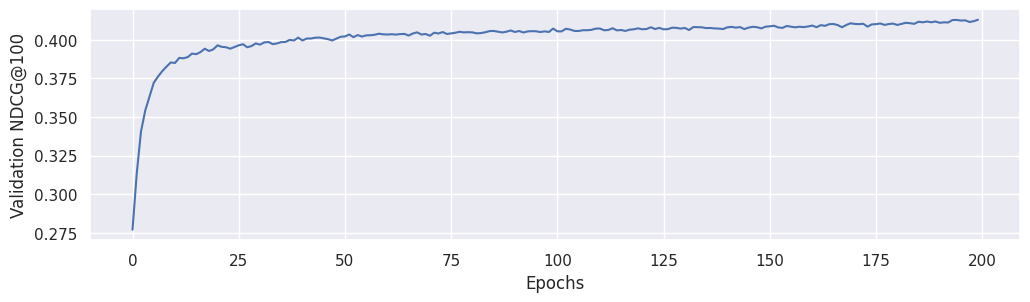

In [ ]:
plt.figure(figsize=(12, 3))
plt.plot(ndcg_history)
plt.ylabel('Validation NDCG@100')
plt.xlabel('Epochs')
plt.show()

In [ ]:
test_train_num = pd.read_csv(os.path.join(output_dir, 'test_train.csv'))
test_test_num  = pd.read_csv(os.path.join(output_dir, 'test_test.csv'))

test_tr_mat, test_te_mat = build_train_test_mats(test_train_num, test_test_num, num_items)

def to_pos_binary(mat_csr):
    m = mat_csr.tocsr(copy=True)
    m.data = (m.data > 0).astype(np.float32)
    m.eliminate_zeros()
    return m

def to_neg_binary(mat_csr):
    m = mat_csr.tocsr(copy=True)
    m.data = (m.data < 0).astype(np.float32)
    m.eliminate_zeros()
    return m

test_te_pos = to_pos_binary(test_te_mat)
test_te_neg = to_neg_binary(test_te_mat)

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

vae_eval = VariationalAutoEncoder(latent_dims, lam=0.0, random_seed=98765)
saver_eval, logits_eval, _, _, _ = vae_eval.build_graph()

ckpt_path = tf.train.latest_checkpoint(ckpt_dir)
if ckpt_path is None:
    index_files = sorted(
        glob.glob(os.path.join(ckpt_dir, '**', '*.index'), recursive=True),
        key=os.path.getmtime
    )
    if not index_files:
        raise FileNotFoundError(f'No TensorFlow checkpoints found under {ckpt_dir}')
    ckpt_path = index_files[-1].replace('.index', '')

print('Restoring checkpoint:', ckpt_path)

N_test = test_tr_mat.shape[0]
idxlist_test = np.arange(N_test, dtype=np.int64)
batch_size_test = 2000

ndcg100_list, recall20_list, recall50_list, neghit100_list = [], [], [], []

with tf.compat.v1.Session() as sess:
    saver_eval.restore(sess, ckpt_path)

    for st_idx in range(0, N_test, batch_size_test):
        end_idx = min(st_idx + batch_size_test, N_test)
        batch_idx = idxlist_test[st_idx:end_idx]

        X = test_tr_mat[batch_idx]
        X_dense = X.toarray().astype(np.float32, copy=False)

        feed_dict = {
            vae_eval.input_ph: X_dense,
            vae_eval.keep_prob_ph: 1.0,
            vae_eval.is_training_ph: 0.0
        }

        pred = sess.run(logits_eval, feed_dict=feed_dict)

        pred[X_dense.nonzero()] = -np.inf

        y_pos = test_te_pos[batch_idx]
        y_neg = test_te_neg[batch_idx]

        ndcg100_list.append(ndcg_score_batch(pred, y_pos, k=100))
        recall20_list.append(recall_at_k_batch(pred, y_pos, k=20))
        recall50_list.append(recall_at_k_batch(pred, y_pos, k=50))
        neghit100_list.append(negative_hit_rate_batch(pred, y_neg, k=100))

ndcg100  = np.concatenate(ndcg100_list).astype(np.float32)
r20      = np.concatenate(recall20_list).astype(np.float32)
r50      = np.concatenate(recall50_list).astype(np.float32)
negh100  = np.concatenate(neghit100_list).astype(np.float32)

def mean_se(x: np.ndarray) -> Tuple[float, float]:
    x = x[np.isfinite(x)]
    if x.size == 0:
        return 0.0, 0.0
    return float(x.mean()), float(x.std(ddof=0) / np.sqrt(x.size))

m_ndcg, se_ndcg   = mean_se(ndcg100)
m_r20,  se_r20    = mean_se(r20)
m_r50,  se_r50    = mean_se(r50)
m_negh, se_negh   = mean_se(negh100)

print(f'Test NDCG@100 = {m_ndcg:.5f} ({se_ndcg:.5f})')
print(f'Test Recall@20 = {m_r20:.5f} ({se_r20:.5f})')
print(f'Test Recall@50 = {m_r50:.5f} ({se_r50:.5f})')

In [ ]:
import numpy as np
import bottleneck as bn
from scipy import sparse
import glob
import tensorflow as tf


def precision_at_k_batch(X_pred, heldout_batch, k=100):
    batch_users = X_pred.shape[0]
    idx = bn.argpartition(-X_pred, k, axis=1)[:, :k]
    X_pred_binary = np.zeros_like(X_pred, dtype=bool)
    X_pred_binary[np.arange(batch_users)[:, None], idx] = True
    X_true_binary = (heldout_batch > 0).toarray()
    precision = (np.logical_and(X_true_binary, X_pred_binary).sum(axis=1)).astype(np.float32) / k
    return precision

def map_at_k_batch(X_pred, heldout_batch, k=100):
    batch_users = X_pred.shape[0]
    idx_part = bn.argpartition(-X_pred, k, axis=1)[:, :k]
    topk_part = X_pred[np.arange(batch_users)[:, None], idx_part]
    idx_sort = np.argsort(-topk_part, axis=1)
    idx_topk = idx_part[np.arange(batch_users)[:, None], idx_sort]

    X_true = (heldout_batch > 0).toarray().astype(np.float32)
    ap = np.zeros(batch_users, dtype=np.float32)
    for u in range(batch_users):
        hits = 0.0
        sum_precisions = 0.0
        for rank, item_idx in enumerate(idx_topk[u], start=1):
            if X_true[u, item_idx] > 0:
                hits += 1
                sum_precisions += hits / rank
        n_relevant = float(min(X_true[u].sum(), k))
        ap[u] = sum_precisions / n_relevant if n_relevant > 0 else 0.0
    return ap

def mrr_at_k_batch(X_pred, heldout_batch, k=100):
    batch_users = X_pred.shape[0]
    idx_part = bn.argpartition(-X_pred, k, axis=1)[:, :k]
    topk_part = X_pred[np.arange(batch_users)[:, None], idx_part]
    idx_sort = np.argsort(-topk_part, axis=1)
    idx_topk = idx_part[np.arange(batch_users)[:, None], idx_sort]

    X_true = (heldout_batch > 0).toarray().astype(np.bool_)
    mrr = np.zeros(batch_users, dtype=np.float32)
    for u in range(batch_users):
        ranks = np.where(X_true[u, idx_topk[u]])[0]
        if ranks.size > 0:
            mrr[u] = 1.0 / (ranks[0] + 1)
        else:
            mrr[u] = 0.0
    return mrr

def hit_rate_at_k_batch(X_pred, heldout_batch, k=100):
    batch_users = X_pred.shape[0]
    idx = bn.argpartition(-X_pred, k, axis=1)[:, :k]
    X_pred_binary = np.zeros_like(X_pred, dtype=bool)
    X_pred_binary[np.arange(batch_users)[:, None], idx] = True
    X_true_binary = (heldout_batch > 0).toarray()
    hits = (np.logical_and(X_true_binary, X_pred_binary).sum(axis=1) > 0).astype(np.float32)
    return hits

test_train_num = pd.read_csv(os.path.join(output_dir, 'test_train.csv'))
test_test_num  = pd.read_csv(os.path.join(output_dir, 'test_test.csv'))
test_tr_mat, test_te_mat = build_train_test_mats(test_train_num, test_test_num, num_items)

test_te_pos = to_pos_binary(test_te_mat)
test_te_neg = to_neg_binary(test_te_mat)

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

vae_eval = VariationalAutoEncoder(latent_dims, lam=0.0, random_seed=98765)
saver_eval, logits_eval, _, _, _ = vae_eval.build_graph()

ckpt_path = tf.train.latest_checkpoint(ckpt_dir)
if ckpt_path is None:
    index_files = sorted(glob.glob(os.path.join(ckpt_dir, '**', '*.index'), recursive=True),
                         key=os.path.getmtime)
    if not index_files:
        raise FileNotFoundError(f'No checkpoints found in {ckpt_dir}')
    ckpt_path = index_files[-1].replace('.index', '')

print(f'Restoring checkpoint: {ckpt_path}')

N_test = test_tr_mat.shape[0]
idxlist_test = np.arange(N_test, dtype=np.int64)
batch_size_test = 2000

ndcg100_list   = []
recall20_list  = []
recall50_list  = []
neghit100_list = []
precision20_list  = []
precision50_list  = []
precision100_list = []
map100_list    = []
mrr100_list    = []
hit20_list     = []
hit50_list     = []
hit100_list    = []

with tf.compat.v1.Session() as sess:
    saver_eval.restore(sess, ckpt_path)

    for st_idx in range(0, N_test, batch_size_test):
        end_idx = min(st_idx + batch_size_test, N_test)
        batch_idx = idxlist_test[st_idx:end_idx]

        X = test_tr_mat[batch_idx]
        X_dense = X.toarray().astype(np.float32, copy=False)

        feed_dict = {
            vae_eval.input_ph: X_dense,
            vae_eval.keep_prob_ph: 1.0,
            vae_eval.is_training_ph: 0.0
        }

        preds = sess.run(logits_eval, feed_dict=feed_dict)

        preds[X_dense.nonzero()] = -np.inf

        heldout_pos = test_te_pos[batch_idx]
        heldout_neg = test_te_neg[batch_idx]

        ndcg100_list.append(ndcg_score_batch(preds, heldout_pos, k=100))
        recall20_list.append(recall_at_k_batch(preds, heldout_pos, k=20))
        recall50_list.append(recall_at_k_batch(preds, heldout_pos, k=50))
        neghit100_list.append(negative_hit_rate_batch(preds, heldout_neg, k=100))

        precision20_list.append(precision_at_k_batch(preds, heldout_pos, k=20))
        precision50_list.append(precision_at_k_batch(preds, heldout_pos, k=50))
        precision100_list.append(precision_at_k_batch(preds, heldout_pos, k=100))

        map100_list.append(map_at_k_batch(preds, heldout_pos, k=100))
        mrr100_list.append(mrr_at_k_batch(preds, heldout_pos, k=100))

        hit20_list.append(hit_rate_at_k_batch(preds, heldout_pos, k=20))
        hit50_list.append(hit_rate_at_k_batch(preds, heldout_pos, k=50))
        hit100_list.append(hit_rate_at_k_batch(preds, heldout_pos, k=100))

ndcg100  = np.concatenate(ndcg100_list).astype(np.float32)
r20      = np.concatenate(recall20_list).astype(np.float32)
r50      = np.concatenate(recall50_list).astype(np.float32)
negh100  = np.concatenate(neghit100_list).astype(np.float32)
prec20   = np.concatenate(precision20_list).astype(np.float32)
prec50   = np.concatenate(precision50_list).astype(np.float32)
prec100  = np.concatenate(precision100_list).astype(np.float32)
map100   = np.concatenate(map100_list).astype(np.float32)
mrr100   = np.concatenate(mrr100_list).astype(np.float32)
hit20    = np.concatenate(hit20_list).astype(np.float32)
hit50    = np.concatenate(hit50_list).astype(np.float32)
hit100   = np.concatenate(hit100_list).astype(np.float32)

def mean_se(x):
    x = x[np.isfinite(x)]
    if x.size == 0:
        return 0.0, 0.0
    return float(x.mean()), float(x.std(ddof=0) / np.sqrt(x.size))

metrics = {
    'NDCG@100'      : ndcg100,
    'Recall@20'     : r20,
    'Recall@50'     : r50,
    'Precision@20'  : prec20,
    'Precision@50'  : prec50,
    'Precision@100' : prec100,
    'MAP@100'       : map100,
    'MRR@100'       : mrr100,
    'HitRate@20'    : hit20,
    'HitRate@50'    : hit50,
    'HitRate@100'   : hit100,
}

for name, values in metrics.items():
    mean, se = mean_se(values)
    print(f'{name:14s} = {mean:.5f} (±{se:.5f})')


Restoring checkpoint: /content/drive/MyDrive/Shortcuts/MovieLens/ml-20m/checkpoints/ml-20m/VAE_200K_cap2.0E-01/I-600-200-600-I/model
NDCG@100       = 0.41150 (±0.00229)
Recall@20      = 0.37886 (±0.00274)
Recall@50      = 0.48402 (±0.00287)
Precision@20   = 0.19624 (±0.00185)
Precision@50   = 0.12790 (±0.00132)
Precision@100  = 0.08636 (±0.00097)
MAP@100        = 0.20656 (±0.00182)
MRR@100        = 0.53227 (±0.00408)
HitRate@20     = 0.84740 (±0.00360)
HitRate@50     = 0.90180 (±0.00298)
HitRate@100    = 0.93090 (±0.00254)


# Cyclic Beta Annealing

Starting training with 4 cycles of KL annealing...
Epoch 000 | Loss: 552.38 | Val NDCG: 0.29445 | Current Beta: 0.0080
Epoch 010 | Loss: 482.30 | Val NDCG: 0.41031 | Current Beta: 0.0880
Epoch 020 | Loss: 480.05 | Val NDCG: 0.41529 | Current Beta: 0.1680
Epoch 030 | Loss: 478.83 | Val NDCG: 0.41561 | Current Beta: 0.2000
Epoch 040 | Loss: 477.21 | Val NDCG: 0.41873 | Current Beta: 0.2000
Epoch 050 | Loss: 460.27 | Val NDCG: 0.42094 | Current Beta: 0.0080
Epoch 060 | Loss: 467.63 | Val NDCG: 0.42037 | Current Beta: 0.0880
Epoch 070 | Loss: 471.98 | Val NDCG: 0.42008 | Current Beta: 0.1680
Epoch 080 | Loss: 473.86 | Val NDCG: 0.42230 | Current Beta: 0.2000
Epoch 090 | Loss: 473.17 | Val NDCG: 0.42135 | Current Beta: 0.2000
Epoch 100 | Loss: 455.62 | Val NDCG: 0.42179 | Current Beta: 0.0080
Epoch 110 | Loss: 463.93 | Val NDCG: 0.42244 | Current Beta: 0.0880
Epoch 120 | Loss: 469.69 | Val NDCG: 0.42302 | Current Beta: 0.1680
Epoch 130 | Loss: 471.52 | Val NDCG: 0.42234 | Current Beta: 0.20

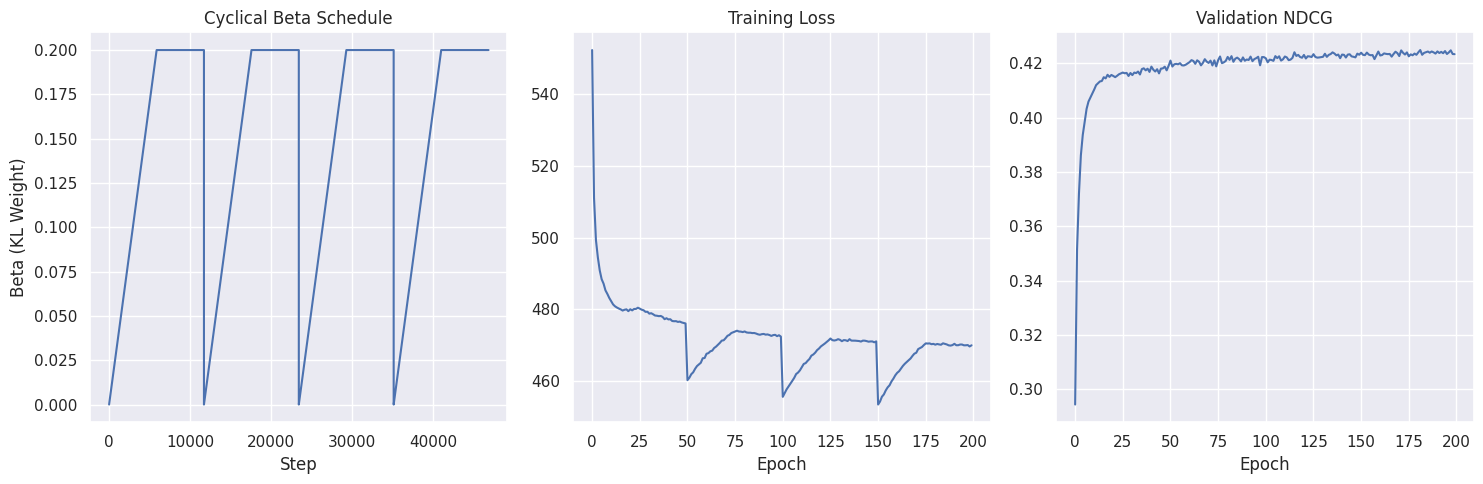

In [ ]:
n_cycles = 4
total_steps = n_epochs * batches_per_epoch
cycle_length = total_steps // n_cycles

train_losses = []
val_ndcgs = []
beta_values = []

with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())

    best_ndcg = -np.inf
    update_count = 0.0

    print(f"Starting training with {n_cycles} cycles of KL annealing...")

    for epoch in range(n_epochs):
        np.random.shuffle(idxlist)
        epoch_loss = 0.0

        for bnum, st_idx in enumerate(range(0, N, batch_size)):
            end_idx = min(st_idx + batch_size, N)

            X = train_data[idxlist[st_idx:end_idx]]
            if sparse.isspmatrix(X):
                X = X.toarray()
            X = X.astype(np.float32, copy=False)

            cycle_progress = (update_count % cycle_length) / cycle_length

            if cycle_progress < 0.5:
                anneal = (cycle_progress / 0.5) * anneal_cap
            else:
                anneal = anneal_cap

            beta_values.append(anneal)

            feed_dict = {
                vae.input_ph: X,
                vae.keep_prob_ph: 0.5,
                vae.anneal_ph: anneal,
                vae.is_training_ph: 1.0,
            }

            _, batch_loss = sess.run([train_op_var, loss_var], feed_dict=feed_dict)
            epoch_loss += batch_loss
            update_count += 1.0

        train_losses.append(epoch_loss / batches_per_epoch)


        ndcg_dist = []
        for bnum, st_idx in enumerate(range(0, N_vad, batch_size_vad)):
            end_idx = min(st_idx + batch_size_vad, N_vad)
            X = vad_data_tr[idxlist_vad[st_idx:end_idx]]
            if sparse.isspmatrix(X):
                X = X.toarray()
            X = X.astype(np.float32, copy=False)

            pred_val = sess.run(logits_var, feed_dict={vae.input_ph: X})
            pred_val[X.nonzero()] = -np.inf

            ndcg_dist.append(
                NDCG_binary_at_k_batch(pred_val, vad_data_te[idxlist_vad[st_idx:end_idx]])
            )

        ndcg_dist = np.concatenate(ndcg_dist).astype(np.float32)
        ndcg_ = float(ndcg_dist[np.isfinite(ndcg_dist)].mean())
        val_ndcgs.append(ndcg_)

        if epoch % 10 == 0:
            print(f"Epoch {epoch:03d} | Loss: {train_losses[-1]:.2f} | Val NDCG: {ndcg_:.5f} | Current Beta: {anneal:.4f}")

        if ndcg_ > best_ndcg:
            saver.save(sess, os.path.join(chkpt_dir, "model_cyclical"))
            best_ndcg = ndcg_

print(f"\nTraining Complete. Best Validation NDCG: {best_ndcg:.5f}")

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(beta_values)
plt.title("Cyclical Beta Schedule")
plt.xlabel("Step")
plt.ylabel("Beta (KL Weight)")

plt.subplot(1, 3, 2)
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")

plt.subplot(1, 3, 3)
plt.plot(val_ndcgs)
plt.title("Validation NDCG")
plt.xlabel("Epoch")

plt.tight_layout()
plt.show()

# Data Analysis

User‑ and item‑activity distributions. Plot histograms of how many items each user interacts with and how many users each item attracts.

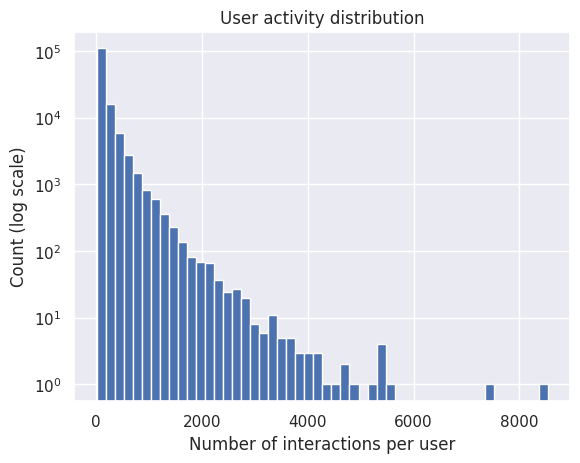

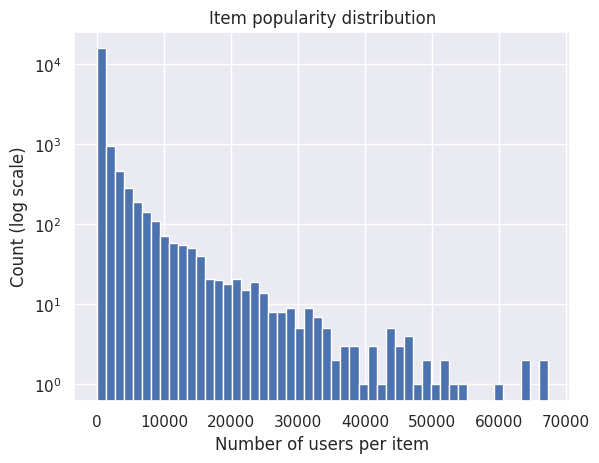

In [ ]:
# Distribution of interactions per user
plt.figure()
plt.hist(user_counts.values, bins=50, log=True)
plt.xlabel('Number of interactions per user')
plt.ylabel('Count (log scale)')
plt.title('User activity distribution')
plt.show()

# Distribution of interactions per item
plt.figure()
plt.hist(item_counts.values, bins=50, log=True)
plt.xlabel('Number of users per item')
plt.ylabel('Count (log scale)')
plt.title('Item popularity distribution')
plt.show()

Latent space visualisation. After training, we projected user or item embeddings into 2D using t‑SNE or UMAP to see if similar users/items cluster together. For example, to visualise user latent vectors:

In [ ]:
from sklearn.manifold import TSNE

with tf.compat.v1.Session() as sess:
    saver.restore(sess, ckpt_path)
    z_mu = []
    for st_idx in range(0, N, batch_size):
        batch = train_mat[st_idx:st_idx + batch_size].toarray()
        feed = {vae_eval.input_ph: batch, vae_eval.keep_prob_ph: 1.0, vae_eval.is_training_ph: 0.0}
        mu, _, _ = sess.run(vae_eval.q_network(), feed_dict=feed)
        z_mu.append(mu)
    z_mu = np.vstack(z_mu)

tsne = TSNE(n_components=2, perplexity=30)
z_emb = tsne.fit_transform(z_mu)

plt.figure()
plt.scatter(z_emb[:, 0], z_emb[:, 1], alpha=0.5, s=5)
plt.title('t-SNE projection of user embeddings')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()


In [ ]:

print("\n--- Starting Tag Genome Analysis ---\n")

movies_df = pd.read_csv(os.path.join(DATA_DIR, 'movies.csv')).set_index('movieId')
genome_scores = pd.read_csv(os.path.join(DATA_DIR, 'genome-scores.csv'))
genome_tags = pd.read_csv(os.path.join(DATA_DIR, 'genome-tags.csv')).set_index('tagId')

print("Building Genome Matrix...")
movie_genome_matrix = genome_scores.pivot(index='movieId', columns='tagId', values='relevance')

with tf.compat.v1.Session() as sess:
    saver.restore(sess, '{}/model_cyclical'.format(chkpt_dir))

    decoder_weights = sess.run(vae.weights_p[-1])

item_embeddings = decoder_weights.T

norms = np.linalg.norm(item_embeddings, axis=1, keepdims=True)
normalized_embeddings = item_embeddings / (norms + 1e-10)

def get_movie_dna(movie_id, top_n=5):
    """Returns the top N tags (Genes) for a movie from the Genome."""
    if movie_id not in movie_genome_matrix.index:
        return ["(No Genome Data)"]

    scores = movie_genome_matrix.loc[movie_id]
    top_tags_idx = scores.sort_values(ascending=False).head(top_n).index

    tags = genome_tags.loc[top_tags_idx]['tag'].values
    values = scores.loc[top_tags_idx].values
    return [f"{t} ({v:.2f})" for t, v in zip(tags, values)]

def explain_similarity(query_movie_title):
    matches = movies_df[movies_df['title'].str.contains(query_movie_title, case=False)]
    if matches.empty:
        print(f"Movie '{query_movie_title}' not found.")
        return

    query_id = matches.index[0]
    title = matches.iloc[0]['title']

    if query_id not in show2id:
        print(f"Movie '{title}' was filtered out (too few ratings).")
        return

    internal_id = show2id[query_id]

    query_vec = normalized_embeddings[internal_id].reshape(1, -1)
    sim_scores = np.dot(query_vec, normalized_embeddings.T).flatten()

    top_indices = np.argsort(sim_scores)[-6:-1][::-1]

    print(f"Query: {title} [ID: {query_id}]")
    print(f"Top Genome Tags: {get_movie_dna(query_id)}")
    print("-" * 60)
    print(f"{'Similarity':<10} | {'Movie Title':<40} | {'Dominant Shared Genes'}")
    print("-" * 60)

    for idx in top_indices:
        neighbor_vid = int(unique_sid[idx])

        try:
            neighbor_title = movies_df.loc[neighbor_vid]['title']
            score = sim_scores[idx]

            dna = get_movie_dna(neighbor_vid, top_n=3)
            dna_str = ", ".join([x.split('(')[0] for x in dna])

            print(f"{score:.4f}     | {neighbor_title[:38]:<40} | {dna_str}")
        except KeyError:
            print(f"{sim_scores[idx]:.4f}     | Movie ID {neighbor_vid} (No Meta)      | ---")

# Re-run the experiments
explain_similarity("Toy Story")
print("\n")
explain_similarity("Pulp Fiction")
print("\n")
explain_similarity("Matrix, The")



--- Starting Tag Genome Analysis ---

Building Genome Matrix...
Query: Toy Story (1995) [ID: 1]
Top Genome Tags: ['toys (1.00)', 'computer animation (1.00)', 'pixar animation (1.00)', 'kids and family (0.99)', 'animation (0.99)']
------------------------------------------------------------
Similarity | Movie Title                              | Dominant Shared Genes
------------------------------------------------------------
0.7192     | Twelve Monkeys (a.k.a. 12 Monkeys) (19   | future , time loop , time travel 
0.7009     | Star Wars: Episode IV - A New Hope (19   | space opera , scifi , sci fi 
0.6882     | Fargo (1996)                             | coen bros , dark humor , imdb top 250 
0.6434     | Aladdin (1992)                           | disney animated feature , kids and family , animation 
0.6421     | Birdcage, The (1996)                     | cross dressing , gay , gay character 


Query: Pulp Fiction (1994) [ID: 296]
Top Genome Tags: ['hit men (1.00)', 'gratuitous violen